In [3]:
!pip install rich

     |████████████████████████████████| 215 kB 5.0 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 


## 모듈 불러오기

In [201]:
import pandas as pd
import numpy as np
import os
import re
import rich  # 출력을 예쁘게 꾸며주는 라이브러리
from rich.table import Table

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from tqdm.auto import tqdm

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## 데이터 불러오기 -> mecab 전처리 완료된

In [21]:
news = pd.read_csv('./drive/MyDrive/final_df.csv', index_col=0) 
news.tail()

,name,headline,date,change,token_mecab
233699,SK하이닉스,"""코로나 봉쇄로 삼성 시안공장 생산 줄여…메모리 공급사 주가에는 긍정적 영향""",2021-12-30,1,코로나 봉쇄 삼성 시안 공장 생산 메모리 공급 주가 긍정 영향
233700,SK하이닉스,"SK하이닉스, 인텔 낸드 1단계 인수",2021-12-30,1,SK 하이닉스 인텔 낸드 단계 인수
233701,SK하이닉스,"SK하이닉스, 특별성과급 300% 쏜다",2021-12-30,1,SK 하이닉스 특별
233702,셀트리온,"삼성바이오로직스-셀트리온, 바이오 대장주 희비",2021-12-30,0,삼성 바이오 로직스 트리 장주 희비
233703,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0,배당락 코스피 하락 예상


In [22]:
news.date = news.date.astype('datetime64[ns]') # 데이터 타입 변경

In [23]:
news['date'] = pd.to_datetime(news['date'])

split_date = pd.to_datetime('2020-01-01')

train = news[news['date'] < split_date]
test = news[news['date'] >= split_date]

In [24]:
len(train), len(test)

(188530, 45174)

In [25]:
train.dropna(how='any', inplace=True) # 널값 제거
test.dropna(how='any', inplace=True) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
train.reset_index(inplace=True); test.reset_index(inplace=True)

In [27]:
train.drop(columns='index', axis=1, inplace=True); test.drop(columns='index', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
train.head()

,name,headline,date,change,token_mecab
0,삼성전자,"[TV] 재계 총수들, 일자리 창출과 투자 확대 강조",2012-01-02,1,TV 재계 총수 일자리 창출 투자 확대 강조
1,셀트리온,"코스닥, 새해 첫 거래일 소폭 오름세 지속",2012-01-02,0,코스닥 새해 거래일 소폭 오름세 지속
2,셀트리온,코스닥 새해 첫 거래일 소폭 오름세 지속,2012-01-02,0,코스닥 새해 거래일 소폭 오름세 지속
3,셀트리온,"코스닥, 개인·기관 '사자'에 상승 지속…저출산株 강세",2012-01-02,0,코스닥 개인 기관 사자 상승 지속 저출산 종목 강세
4,셀트리온,"코스피, 외인 '팔자'에 약세 전환…방향성 탐색",2012-01-02,0,코스피 외인 팔자 약세 전환 방향 탐색


In [29]:
columns = ['date', 'name', 'headline', 'token_mecab', 'change']
train = train[columns]; test = test[columns]

In [30]:
train.head()

,date,name,headline,token_mecab,change
0,2012-01-02,삼성전자,"[TV] 재계 총수들, 일자리 창출과 투자 확대 강조",TV 재계 총수 일자리 창출 투자 확대 강조,1
1,2012-01-02,셀트리온,"코스닥, 새해 첫 거래일 소폭 오름세 지속",코스닥 새해 거래일 소폭 오름세 지속,0
2,2012-01-02,셀트리온,코스닥 새해 첫 거래일 소폭 오름세 지속,코스닥 새해 거래일 소폭 오름세 지속,0
3,2012-01-02,셀트리온,"코스닥, 개인·기관 '사자'에 상승 지속…저출산株 강세",코스닥 개인 기관 사자 상승 지속 저출산 종목 강세,0
4,2012-01-02,셀트리온,"코스피, 외인 '팔자'에 약세 전환…방향성 탐색",코스피 외인 팔자 약세 전환 방향 탐색,0


## 머신러닝 분류기
- tf-idf로 벡터화 진행 후(analyzer는 단어 단위, ngram은 최대 3어절까지) 5-fold cv 진행(과적합 방지)
- 4개의 머신러닝 분류기(naive_bayes, sgd, lgbm, xgboost)에 대해 stacking

### 모델 파이프라인

In [43]:
def get_pipe(model, model_name: str) -> Pipeline:
    "TfidfVectorizer와 모델을 연결한 파이프라인을 반환하는 함수"
    tfidf = TfidfVectorizer(analyzer="word", ngram_range=(1, 3))
    pipe = Pipeline([
        ("tfidf", tfidf),
        (model_name, model)
    ])
    return pipe

In [41]:
def return_kfold_accuarcy(model, k: int = 5) -> float:
    "모델을 입력받아 KFold 예측 후 accuracy score를 반환하는 함수"
    kfold = StratifiedKFold(k, shuffle=True, random_state=42)
    result = []
    cnt = 0
    for train_idx, test_idx in kfold.split(train["token_mecab"], train["change"]):
        train_new, val = train.iloc[train_idx], train.iloc[test_idx]
        model.fit(train_new["token_mecab"], train_new["change"])
        pred = model.predict(val["token_mecab"])
        acc = accuracy_score(val["change"], pred)
        result.append(acc)
        cnt += 1
        print(f'{cnt}th complete!')

    return np.mean(result)

In [42]:
models = [
    ("naive_bayes", BernoulliNB()),
    ("SGD", SGDClassifier(random_state=42, n_jobs=-1)),
    ("lgbm", LGBMClassifier(random_state=42)),
    ("xgb", XGBClassifier(random_state=42))
]

model_pipes = [(name, get_pipe(model, name)) for name, model in models]

In [44]:
table = Table(title="Model Comparison Table")
table.add_column("Model Name", justify="left", style="green")
table.add_column("Accuracy", justify="right")

for model_name, model in tqdm(model_pipes, leave=False):
    print(f'##################### {model_name} #################### ')
    acc = return_kfold_accuarcy(model)
    table.add_row(model_name, f"{acc:0.3f}")

rich.print(table)

  0%|          | 0/4 [00:00<?, ?it/s]

##################### naive_bayes #################### 
1th complete!
2th complete!
3th complete!
4th complete!
5th complete!
##################### SGD #################### 
1th complete!
2th complete!
3th complete!
4th complete!
5th complete!
##################### lgbm #################### 
1th complete!
2th complete!
3th complete!
4th complete!
5th complete!
##################### xgb #################### 
1th complete!
2th complete!
3th complete!
4th complete!
5th complete!


  Model Comparison Table  
┏━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Model Name  ┃ Accuracy ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ naive_bayes │    0.597 │
│ SGD         │    0.542 │
│ lgbm        │    0.553 │
│ xgb         │    0.544 │
└─────────────┴──────────┘

### stacking ensemble
- 4개의 개별 모델이 예측한 데이터를 다시 training set으로 사용해서 학습
- 최종 model을 하나 선정해 학습 후 test set 평가

In [45]:
from sklearn.ensemble import StackingClassifier

stack_models = [(name, get_pipe(model, name)) for name, model in models]

stacking = StackingClassifier(stack_models)
acc = return_kfold_accuarcy(stacking)
rich.print(acc)

1th complete!
2th complete!
3th complete!
4th complete!
5th complete!


0.5492119465482872

In [46]:
stacking.fit(train['token_mecab'], train['change'])

## test set 평가 준비
-  예측기로서 동작할 수 있는 Selection Function을 만들어야함
- 특정날짜의 주가 기사문장이 N개라고 했을 때, N개의 문장의 감성 분류스코어를 계산한 확률평균을 그날 주식 종가의 업다운을 결정하는 예측 값으로 사용
- 문장 판별 확률의 평균으로 선택한 이유 -> 일반화된 테스트 데이터가 아님

### 종목별 예측값 mapping df 생성

In [50]:
pred_result = stacking.predict(test['token_mecab'])

In [66]:
test['result'] = pred_result

In [77]:
test.head(3)

,date,name,headline,token_mecab,change,result
0,2020-01-02,카카오,"""기술 사대주의로는 AI 정복 힘들다""",기술 사대주의 AI 정복 힘들,0,0
1,2020-01-02,카카오,[해설]中 디지털 종속 우려...동남아 국가 '中 QR결제 금지' 초강수,해설 중국 디지털 종속 우려 동남아 국가 중국 QR 결제 금지 강수,0,0
2,2020-01-02,카카오,"씨티은행, 1.3%포인트 금리인하 직장인 신용대출..한달 연장 이벤트",씨티 은행 포인트 금리 인하 직장 신용 대출 연장 이벤트,0,0


In [78]:
len(test['date'].unique()) # test set -> 2년치 데이터인지 확인

496

In [79]:
stock_result_list = []
for name in tqdm(test['name'].unique()): # 10개 종목
    temp_list = []
    for date in tqdm(test['date'].unique()): # 일자 별
        avg_result = np.mean(test[(test['date'] == date) & (test['name'] == name)]['result']) # 일자별 예측 평균 값
        temp_list.append(avg_result)  
    stock_result_list.append(temp_list)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

In [127]:
result_df = pd.DataFrame({'카카오': stock_result_list[0]}, index=test['date'].unique())

for idx, name in enumerate(test['name'].unique()[1:]):
    result_df[name] = stock_result_list[idx + 1]

In [128]:
result_df.sort_index(inplace=True)

In [129]:
result_df.head()

,카카오,SK하이닉스,KB금융,신한지주,삼성전자,셀트리온,현대차,LG화학,POSCO,NAVER
2020-01-02,0.055556,0.090909,0.0,0.1,0.083333,0.375000,0.000000,0.0,0.142857,0.00
2020-01-03,0.285714,0.833333,0.0,0.0,0.153846,0.125000,0.076923,0.2,1.000000,0.00
2020-01-06,0.062500,0.000000,0.0,0.5,0.000000,0.250000,0.000000,0.0,0.000000,0.00
2020-01-07,0.000000,0.307692,0.0,NaN,0.000000,0.666667,0.000000,0.0,0.000000,0.25
2020-01-08,0.052632,0.428571,0.0,0.2,0.000000,0.000000,0.083333,0.0,0.000000,0.40


In [130]:
result_df.isnull().sum() # 널값 확인

카카오         0
SK하이닉스      1
KB금융        4
신한지주       83
삼성전자        3
셀트리온        1
현대차         1
LG화학        1
POSCO     136
NAVER       6
dtype: int64

- 널 값을 label값과 병합 후에 처리하자

### 종목별 정답 mapping df 생성

In [113]:
change = pd.read_csv('./drive/MyDrive/ten_change.csv', index_col=0) 

In [114]:
change['date'] = pd.to_datetime(change['date'])

split_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-30')

change_test = change[(change['date'] >= split_date) & (change['date'] <= end_date)]

In [115]:
change_test

,date,change,name
1967,2020-01-02,0,삼성전자
1968,2020-01-03,1,삼성전자
1969,2020-01-06,0,삼성전자
1970,2020-01-07,1,삼성전자
1971,2020-01-08,1,삼성전자
...,...,...,...
24715,2021-12-24,0,신한지주
24716,2021-12-27,0,신한지주
24717,2021-12-28,1,신한지주
24718,2021-12-29,0,신한지주


In [116]:
change_df = pd.DataFrame({'삼성전자': change_test[change_test['name'] == '삼성전자']['change'].values}, index=change_test['date'].unique())

In [117]:
for name in change_test['name'].unique()[1:]:
    change_df[name] = change_test[change_test['name'] == name]['change'].values

In [118]:
change_df

,삼성전자,SK하이닉스,NAVER,LG화학,현대차,카카오,셀트리온,POSCO,KB금융,신한지주
2020-01-02,0,1,0,0,0,0,0,0,0,0
2020-01-03,1,0,0,0,0,0,0,1,1,1
2020-01-06,0,0,0,0,0,1,0,0,0,0
2020-01-07,1,0,1,1,0,1,1,1,1,1
2020-01-08,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2021-12-24,1,1,1,0,1,1,0,1,0,0
2021-12-27,0,0,0,1,0,0,1,0,0,0
2021-12-28,1,1,1,1,1,1,1,1,1,1
2021-12-29,0,0,0,0,0,1,0,0,0,0


## 종목별 예측값, 정답 병합

In [131]:
# 각각 데이터프레임 생성
samsung = pd.DataFrame({'predict': result_df['삼성전자'], 'label': change_df['삼성전자']}, index=test['date'].unique())
samsung = samsung.sort_index()

skhynix = pd.DataFrame({'predict': result_df['SK하이닉스'], 'label': change_df['SK하이닉스']}, index=test['date'].unique())
skhynix = skhynix.sort_index()

naver = pd.DataFrame({'predict': result_df['NAVER'], 'label': change_df['NAVER']}, index=test['date'].unique())
naver = naver.sort_index()

lgchem = pd.DataFrame({'predict': result_df['LG화학'], 'label': change_df['LG화학']}, index=test['date'].unique())
lgchem = lgchem.sort_index()

hyundai = pd.DataFrame({'predict': result_df['현대차'], 'label': change_df['현대차']}, index=test['date'].unique())
hyundai = hyundai.sort_index()

kakao = pd.DataFrame({'predict': result_df['카카오'], 'label': change_df['카카오']}, index=test['date'].unique())
kakao = kakao.sort_index()

celtrion = pd.DataFrame({'predict': result_df['셀트리온'], 'label': change_df['셀트리온']}, index=test['date'].unique())
celtrion = celtrion.sort_index()

posco = pd.DataFrame({'predict': result_df['POSCO'], 'label': change_df['POSCO']}, index=test['date'].unique())
posco = posco.sort_index()

kb = pd.DataFrame({'predict': result_df['KB금융'], 'label': change_df['KB금융']}, index=test['date'].unique())
kb = kb.sort_index()

shinhan = pd.DataFrame({'predict': result_df['신한지주'], 'label': change_df['신한지주']}, index=test['date'].unique())
shinhan = shinhan.sort_index()

In [132]:
samsung

,predict,label
2020-01-02,0.083333,0
2020-01-03,0.153846,1
2020-01-06,0.000000,0
2020-01-07,0.000000,1
2020-01-08,0.000000,1
...,...,...
2021-12-24,0.100000,1
2021-12-27,0.000000,0
2021-12-28,0.000000,1
2021-12-29,0.090909,0


### 종목별 널값 처리


In [133]:
result_df.isnull().sum() # 널값 확인

카카오         0
SK하이닉스      1
KB금융        4
신한지주       83
삼성전자        3
셀트리온        1
현대차         1
LG화학        1
POSCO     136
NAVER       6
dtype: int64

In [142]:
# predict에 nan이있는 행을 삭제
samsung = samsung.dropna(subset=["predict"])
skhynix = skhynix.dropna(subset=["predict"])
naver = naver.dropna(subset=['predict'])
lgchem = lgchem.dropna(subset=['predict'])
hyundai = hyundai.dropna(subset=['predict'])
kakao = kakao.dropna(subset=['predict'])
celtrion = celtrion.dropna(subset=['predict'])
posco = posco.dropna(subset=['predict'])
kb = kb.dropna(subset=['predict'])
shinhan = shinhan.dropna(subset=['predict'])

In [144]:
samsung

,predict,label
2020-01-02,0.083333,0
2020-01-03,0.153846,1
2020-01-06,0.000000,0
2020-01-07,0.000000,1
2020-01-08,0.000000,1
...,...,...
2021-12-24,0.100000,1
2021-12-27,0.000000,0
2021-12-28,0.000000,1
2021-12-29,0.090909,0


### 일자별 확률 평균값 다시 라벨링
- 그날의 평균 예측값이 0.5보다 작으면 0(하락), 0.5보다 크거나 같으면 1(상승)


In [ ]:
samsung['predict'][samsung['predict'] < 0.5] = 0
samsung['predict'][samsung['predict'] >= 0.5] = 1

skhynix['predict'][skhynix['predict'] < 0.5] = 0
skhynix['predict'][skhynix['predict'] >= 0.5] = 1

naver['predict'][naver['predict'] < 0.5] = 0
naver['predict'][naver['predict'] >= 0.5] = 1

lgchem['predict'][lgchem['predict'] < 0.5] = 0
lgchem['predict'][lgchem['predict'] >= 0.5] = 1

hyundai['predict'][hyundai['predict'] < 0.5] = 0
hyundai['predict'][hyundai['predict'] >= 0.5] = 1

kakao['predict'][kakao['predict'] < 0.5] = 0
kakao['predict'][kakao['predict'] >= 0.5] = 1

celtrion['predict'][celtrion['predict'] < 0.5] = 0
celtrion['predict'][celtrion['predict'] >= 0.5] = 1

posco['predict'][posco['predict'] < 0.5] = 0
posco['predict'][posco['predict'] >= 0.5] = 1

kb['predict'][kb['predict'] < 0.5] = 0
kb['predict'][kb['predict'] >= 0.5] = 1

shinhan['predict'][shinhan['predict'] < 0.5] = 0
shinhan['predict'][shinhan['predict'] >= 0.5] = 1

In [149]:
celtrion

,predict,label
2020-01-02,0.0,0
2020-01-03,0.0,0
2020-01-06,0.0,0
2020-01-07,1.0,1
2020-01-08,0.0,0
...,...,...
2021-12-24,0.0,0
2021-12-27,0.0,1
2021-12-28,1.0,1
2021-12-29,1.0,0


## 종목별 test set 평가

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 종목별 accuracy 시각화 비교


In [172]:
acc_list = []; company = ['samsung elec', 'sk hynix', 'naver', 'lg chem', 'hyundai car', 'kakao', 'celtrion', 'posco', 'kb finance', 'shinhan']
acc_list.append(accuracy_score(samsung['label'], samsung['predict']))
acc_list.append(accuracy_score(skhynix['label'], skhynix['predict']))
acc_list.append(accuracy_score(naver['label'], naver['predict']))
acc_list.append(accuracy_score(lgchem['label'], lgchem['predict']))
acc_list.append(accuracy_score(hyundai['label'], hyundai['predict']))
acc_list.append(accuracy_score(kakao['label'], kakao['predict']))
acc_list.append(accuracy_score(celtrion['label'], celtrion['predict']))
acc_list.append(accuracy_score(posco['label'], posco['predict']))
acc_list.append(accuracy_score(kb['label'], kb['predict']))
acc_list.append(accuracy_score(shinhan['label'], shinhan['predict']))

In [174]:
acc_df = pd.DataFrame({'company': company, 'accuracy': acc_list})
acc_df.set_index('company', inplace=True)

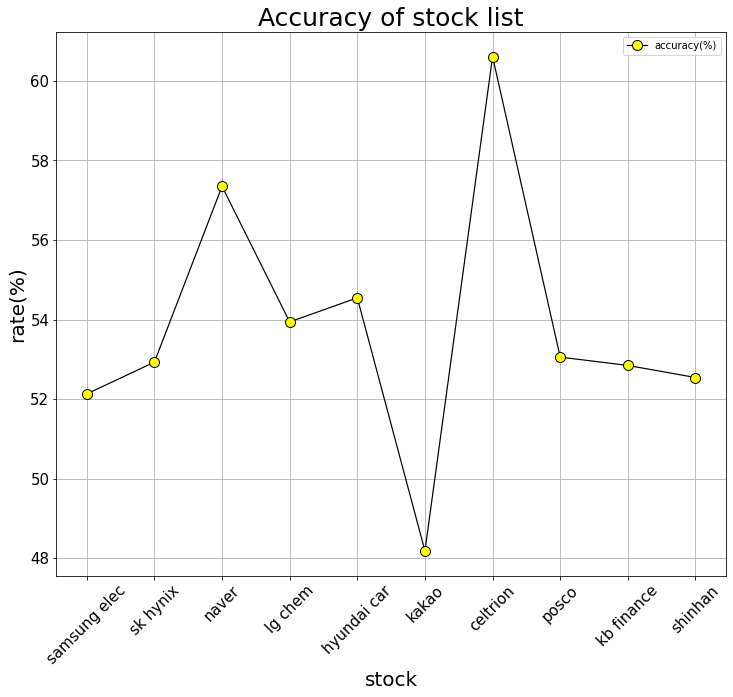

In [180]:
plt.figure(figsize=(12, 10))
plt.plot(acc_df.index, acc_df['accuracy'] * 100,
         label='accuracy(%)',
         linestyle='-',
         linewidth=1.2,
         color='black',
         marker='o',
         markersize=10,
         markerfacecolor='yellow',
         markeredgecolor='black'
)

plt.title('Accuracy of stock list', size=25)
plt.xlabel("stock", size=20)
plt.ylabel("rate(%)", size=20)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(loc='best')
plt.show()

### 종목별 confusion matrix, classification_report

#### 삼성전자

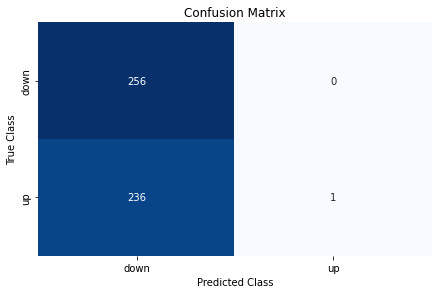

In [205]:
# confusion matrix 시각화
matrix = confusion_matrix(samsung.label, samsung.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [204]:
# classification report
print(classification_report(samsung.label, samsung.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.52      1.00      0.68       256
          up       1.00      0.00      0.01       237

    accuracy                           0.52       493
   macro avg       0.76      0.50      0.35       493
weighted avg       0.75      0.52      0.36       493



#### SK하이닉스

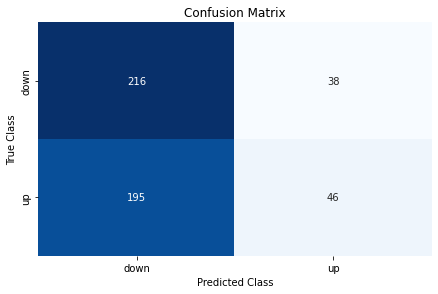

In [206]:
# confusion matrix 시각화
matrix = confusion_matrix(skhynix.label, skhynix.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [208]:
# classification report
print(classification_report(skhynix.label, skhynix.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.53      0.85      0.65       254
          up       0.55      0.19      0.28       241

    accuracy                           0.53       495
   macro avg       0.54      0.52      0.47       495
weighted avg       0.54      0.53      0.47       495



#### NAVER

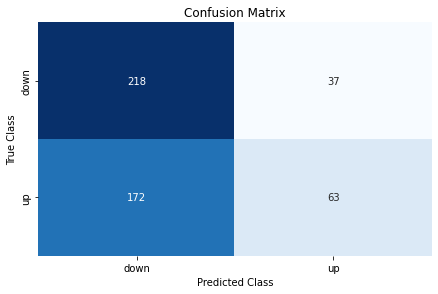

In [209]:
# confusion matrix 시각화
matrix = confusion_matrix(naver.label, naver.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [210]:
# classification report
print(classification_report(naver.label, naver.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.56      0.85      0.68       255
          up       0.63      0.27      0.38       235

    accuracy                           0.57       490
   macro avg       0.59      0.56      0.53       490
weighted avg       0.59      0.57      0.53       490



#### LG화학

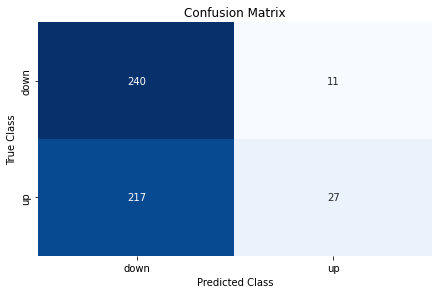

In [211]:
# confusion matrix 시각화
matrix = confusion_matrix(lgchem.label, lgchem.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [212]:
# classification report
print(classification_report(lgchem.label, lgchem.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.53      0.96      0.68       251
          up       0.71      0.11      0.19       244

    accuracy                           0.54       495
   macro avg       0.62      0.53      0.43       495
weighted avg       0.62      0.54      0.44       495



#### 현대차

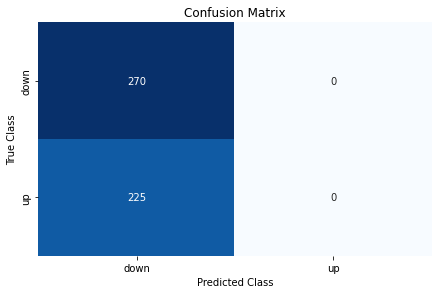

In [213]:
# confusion matrix 시각화
matrix = confusion_matrix(hyundai.label, hyundai.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [214]:
# classification report
print(classification_report(hyundai.label, hyundai.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.55      1.00      0.71       270
          up       0.00      0.00      0.00       225

    accuracy                           0.55       495
   macro avg       0.27      0.50      0.35       495
weighted avg       0.30      0.55      0.39       495



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 카카오

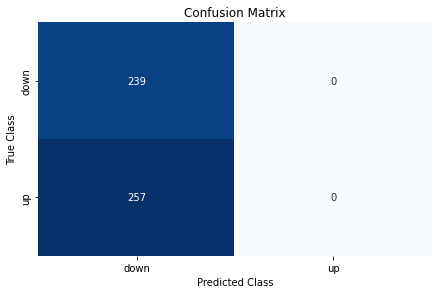

In [215]:
# confusion matrix 시각화
matrix = confusion_matrix(kakao.label, kakao.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [216]:
# classification report
print(classification_report(kakao.label, kakao.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.48      1.00      0.65       239
          up       0.00      0.00      0.00       257

    accuracy                           0.48       496
   macro avg       0.24      0.50      0.33       496
weighted avg       0.23      0.48      0.31       496



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 셀트리온

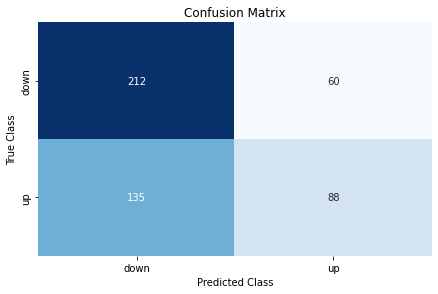

In [217]:
# confusion matrix 시각화
matrix = confusion_matrix(celtrion.label, celtrion.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [218]:
# classification report
print(classification_report(celtrion.label, celtrion.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.61      0.78      0.68       272
          up       0.59      0.39      0.47       223

    accuracy                           0.61       495
   macro avg       0.60      0.59      0.58       495
weighted avg       0.60      0.61      0.59       495



#### POSCO

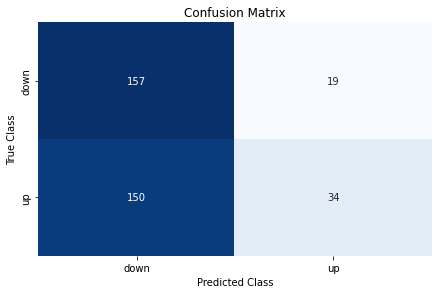

In [219]:
# confusion matrix 시각화
matrix = confusion_matrix(posco.label, posco.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [220]:
# classification report
print(classification_report(posco.label, posco.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.51      0.89      0.65       176
          up       0.64      0.18      0.29       184

    accuracy                           0.53       360
   macro avg       0.58      0.54      0.47       360
weighted avg       0.58      0.53      0.46       360



#### KB금융

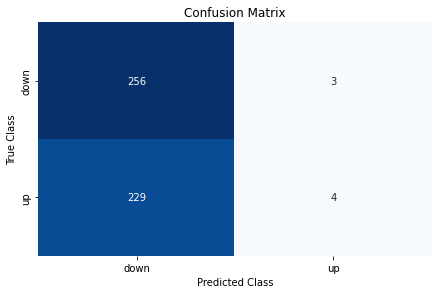

In [221]:
# confusion matrix 시각화
matrix = confusion_matrix(kb.label, kb.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [222]:
# classification report
print(classification_report(kb.label, kb.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.53      0.99      0.69       259
          up       0.57      0.02      0.03       233

    accuracy                           0.53       492
   macro avg       0.55      0.50      0.36       492
weighted avg       0.55      0.53      0.38       492



#### 신한지주

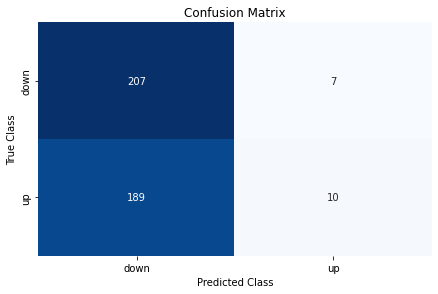

In [224]:
# confusion matrix 시각화
matrix = confusion_matrix(shinhan.label, shinhan.predict)
class_names = ['down', 'up']
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, fmt='d', cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [223]:
# classification report
print(classification_report(shinhan.label, shinhan.predict, target_names=class_names))

              precision    recall  f1-score   support

        down       0.52      0.97      0.68       214
          up       0.59      0.05      0.09       199

    accuracy                           0.53       413
   macro avg       0.56      0.51      0.39       413
weighted avg       0.55      0.53      0.40       413

